In [2]:
from preprocessing import preprocessing_data
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [10]:
# Original data

retards_df = pd.read_csv("data/regularite-mensuelle-tgv-aqst.csv", sep=';')



,nb_train_prevu,nb_train_retard_arrivee,nb_train_depart_retard
0,870,147,289
1,222,34,8
2,248,26,37
3,102,13,12
4,391,71,61


In [3]:
# Preprocess data

train_df_X, train_df_Y, test_df_X, test_df_Y, validate_df_X, validate_df_Y  = preprocessing_data("data/regularite-mensuelle-tgv-aqst.csv")


In [7]:
from pycaret.regression import *
exp_reg = setup(data=train_df_X.join(train_df_Y["total_retard_mean"]), target='total_retard_mean', session_id=42)

best_model_target1 = compare_models()

# Tune the best model for target1
tuned_model_target1 = tune_model(best_model_target1)

# Predict target1

predictions_target1 = predict_model(tuned_model_target1, data=test_df_X)



,Description,Value
0,Session id,42
1,Target,total_retard_mean
2,Target type,Regression
3,Original data shape,"(5942, 126)"
4,Transformed data shape,"(5942, 126)"
5,Transformed train set shape,"(4159, 126)"
6,Transformed test set shape,"(1783, 126)"
7,Numeric features,125
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.4962,0.6024,0.7681,0.3468,0.3187,4.1688,0.0890
rf,Random Forest Regressor,0.5057,0.6160,0.7800,0.3222,0.3256,4.1029,0.3770
gbr,Gradient Boosting Regressor,0.5171,0.6367,0.7918,0.3034,0.3370,4.1233,0.1650
xgboost,Extreme Gradient Boosting,0.5146,0.6517,0.8024,0.2813,0.3261,4.3418,0.4220
et,Extra Trees Regressor,0.5261,0.6581,0.8065,0.2705,0.3278,4.5471,0.3330
ridge,Ridge Regression,0.5380,0.6977,0.8297,0.2345,0.3496,2.8873,0.0110
br,Bayesian Ridge,0.5379,0.6979,0.8298,0.2345,0.3532,2.8422,0.0230
huber,Huber Regressor,0.5218,0.7105,0.8362,0.2240,0.3480,2.6096,0.1700
lr,Linear Regression,0.5458,0.7069,0.8361,0.2199,0.3512,3.1320,0.6020
omp,Orthogonal Matching Pursuit,0.5723,0.7464,0.8592,0.1776,0.3611,3.2232,0.0120


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4905,0.6256,0.7909,0.2524,0.3239,8.2500
1,0.5195,0.7076,0.8412,0.2909,0.3491,2.1178
2,0.4987,0.5187,0.7202,0.3005,0.3175,2.0347
3,0.4674,0.3965,0.6297,0.3698,0.3027,6.2978
4,0.5060,0.5188,0.7203,0.3903,0.3171,1.6843
5,0.4924,0.6376,0.7985,0.3276,0.3389,2.2268
6,0.4902,0.6031,0.7766,0.3414,0.3085,3.1428
7,0.4756,0.4446,0.6667,0.4287,0.2987,1.7780
8,0.5349,0.7125,0.8441,0.2710,0.3341,1.9778


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid to search
param_grid = {
    'n_estimators': [300, 500, 750,1000], 
    'max_features': ['auto', 'sqrt', 'log2'],  
    'max_depth': [None,10, 30,50]
}


rf = RandomForestRegressor(random_state=42)

# Gridsearch
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(train_df_X, train_df_Y["total_retard_mean"])

# Best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


best_rf = RandomForestRegressor(random_state=42, **best_params)
best_rf.fit(train_df_X, train_df_Y["total_retard_mean"])


predictions = best_rf.predict(test_df_X)



"""
best total mean retard
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'max_depth': 30, 'max_features': 'auto', 'n_estimators': 1000}
"""

"""
Best fit all
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 750}
"""

"""
Best fit pcrt
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 750}
"""





Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Hyperparameters: {'max_depth': 30, 'max_features': 'auto', 'n_estimators': 1000}


"\nBest fit pcrt\nFitting 5 folds for each of 36 candidates, totalling 180 fits\nBest Hyperparameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 750}\n"

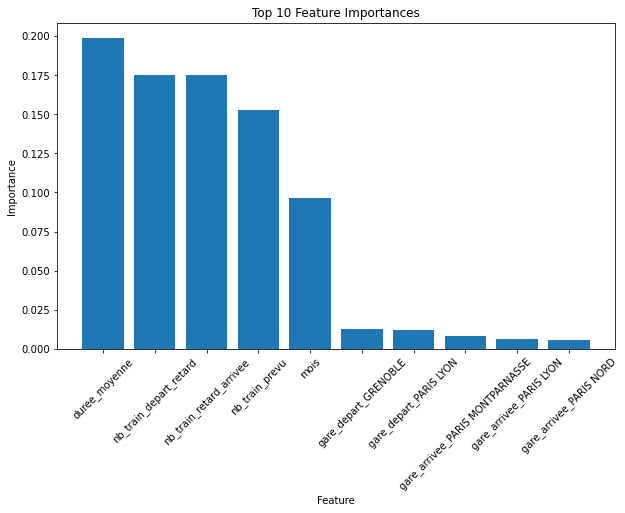

In [8]:
importances = best_rf.feature_importances_
features = train_df_X.columns

# Sort features
indices = np.argsort(importances)[::-1]

# Print most relevant features

top_n = 10  # Number of top features to display
plt.figure(figsize=(10, 6))
plt.title("Top {} Feature Importances".format(top_n))
plt.bar(range(top_n), importances[indices][:top_n], align="center")
plt.xticks(range(top_n), [features[i] for i in indices][:top_n], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

In [6]:
from sklearn.metrics import mean_squared_error, r2_score

#Metrics for total_retard_mean

best_rf = grid_search.best_estimator_


predictions = best_rf.predict(test_df_X)

mse = mean_squared_error(test_df_Y["total_retard_mean"], predictions, squared=False)
r2 = r2_score(test_df_Y["total_retard_mean"], predictions)

print("Mean Squared Error:", mse)
print("R-squared:", r2)




Mean Squared Error: 0.7894078428737914
R-squared: 0.3913748692510495


In [15]:
# Calculate metrics for prediction of retard causes

scores_rmse = []
scores_r2 = []

test_Y_pdrt = test_df_Y.drop("total_retard_mean", axis = 1)

predictions_df = pd.DataFrame(predictions, columns= test_Y_pdrt.columns)

for column in test_Y_pdrt.columns:


    mse = mean_squared_error(test_Y_pdrt[column], predictions_df[column])
    r2 = r2_score(test_Y_pdrt[column], predictions_df[column])

    scores_rmse.append(np.sqrt(mse))
    scores_r2.append(r2)


    print("Column: %s" % column)
    print("Mean Squared Error:", mse)
    print("R-squared:", r2)

print("RMSE Mean %f" % np.mean(scores_rmse))
print("R2 Mean %f" % np.mean(scores_r2))

Column: prct_cause_externe
Mean Squared Error: 0.02188962217553237
R-squared: 0.21901009672603355
Column: prct_cause_infra
Mean Squared Error: 0.023383898734696262
R-squared: 0.19389793357825058
Column: prct_cause_gestion_trafic
Mean Squared Error: 0.013828525535480156
R-squared: 0.2990733268864364
Column: prct_cause_materiel_roulant
Mean Squared Error: 0.01738188480535824
R-squared: 0.1876373509518786
Column: prct_cause_gestion_gare
Mean Squared Error: 0.0049649186520732535
R-squared: 0.0901857908585767
Column: prct_cause_prise_en_charge_voyageurs
Mean Squared Error: 0.007680932527638004
R-squared: 0.20503855714089136
RMSE Mean 0.118068
R2 Mean 0.199141


In [37]:
# Random Forest Grid Search + plot with parameter influence


from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_squared_error, r2_score

from dim_reduction import best_forward_feature_selection

"""
best total mean retard
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'max_depth': 30, 'max_features': 'auto', 'n_estimators': 600}
"""

# Dimensionality reduction test 

feature_list = best_forward_feature_selection()

n_estimators = [100, 200, 400, 600, 800, 1000]
max_depth = [10, 20 ,30 ,40 ,50, 60]

r2_scores = []
mse_scores = []
r2_scores_dim = []
mse_scores_dim = []

for estimator in n_estimators: 

    rf = RandomForestRegressor(n_estimators = estimator , max_features = 'auto', max_depth = 40, random_state =42)

    rf_dim = RandomForestRegressor(n_estimators = estimator , max_features = 'auto', max_depth = 40, random_state =42)

    rf.fit(train_df_X,train_df_Y["total_retard_mean"])

    predictions = rf.predict(test_df_X)


    rf_dim.fit(train_df_X[feature_list],train_df_Y["total_retard_mean"])
    predictions_dim = rf_dim.predict(test_df_X[feature_list])

    # Metric calculation

    r2 = r2_score(test_df_Y["total_retard_mean"], predictions)
    mse = mean_squared_error(test_df_Y["total_retard_mean"], predictions)

    r2_scores.append(r2)
    mse_scores.append(np.sqrt(mse))

    r2 = r2_score(test_df_Y["total_retard_mean"], predictions_dim)
    mse = mean_squared_error(test_df_Y["total_retard_mean"], predictions_dim)

    r2_scores_dim.append(r2)
    mse_scores_dim.append(np.sqrt(mse))


plt.figure(figsize=(10,6))

# r2 plot

# plt.subplot(1, 2, 1)
# plt.plot(n_estimators, r2_scores, marker='o')
# #plt.plot(n_estimators, r2_scores_val, marker='x')

# plt.xlabel('Number of Trees (n_estimators)')
# plt.ylabel('R-squared')
# plt.title('Influence of Number of Trees on R-squared')


# # mse plot

# plt.subplot(1, 2, 2)
# plt.plot(n_estimators, mse_scores, marker='o')
# #plt.plot(n_estimators, mse_scores_val, marker='x')
# plt.xlabel('Number of Trees (n_estimators)')
# plt.ylabel('RMSE')
# plt.title('Influence of Number of Trees on RMSE')

plt.subplot(1, 2, 1)
plt.plot(max_depth, r2_scores, marker='o')
plt.plot(max_depth, r2_scores_dim, marker='x')

plt.xlabel('Max Depth of Trees (max_depth)')
plt.ylabel('R-squared')
plt.title('Influence of Max Depth of Trees on R-squared')


# mse plot

plt.subplot(1, 2, 2)
plt.plot(max_depth, mse_scores, marker='o')
plt.plot(max_depth, mse_scores_dim, marker='x')
plt.xlabel('Max Depth of Trees (max_depth)')
plt.ylabel('RMSE')
plt.title('Influence of Max Depth of Trees on RMSE')

plt.tight_layout()
plt.show()



In [3]:

from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor


# Model not covered in the report as Gradient Boosting was included above


param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 4, 5],
    'num_leaves':[10,20,30]
}

# Model
lgbm = LGBMRegressor(random_state=42)

# Grid Search
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, n_jobs=-1, verbose = 2)

grid_search.fit(train_df_X, train_df_Y["total_retard_mean"])

# Best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters
best_lgbm = LGBMRegressor(random_state=42, **best_params)
best_lgbm.fit(train_df_X, train_df_Y["total_retard_mean"])


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1166
[LightGBM] [Info] Number of data points in the train set: 5942, number of used features: 125
[LightGBM] [Info] Start training from score -0.037283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LGBMRegressor(max_depth=5, n_estimators=300, num_leaves=10, random_state=42)

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


predictions = best_lgbm.predict(test_df_X)


mae = mean_absolute_error(test_df_Y["total_retard_mean"], predictions)
mse = mean_squared_error(test_df_Y["total_retard_mean"], predictions)
r2 = r2_score(test_df_Y["total_retard_mean"], predictions)


print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean Absolute Error (MAE): 0.47256150916502687
Mean Squared Error (MSE): 0.48474317438022824
R-squared (R2): 0.4404253823145149
